In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
from cmapPy.pandasGEXpress import parse

In [2]:
filepath ='GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx'
siginfopath = 'GSE92742_Broad_LINCS_sig_info.txt'
siginfopath = 'GSE92742_Broad_LINCS_sig_info.txt'
geneinfopath = 'GSE92742_Broad_LINCS_gene_info.txt'

sig_info = pd.read_csv(siginfopath, sep="\t")
gene_info = pd.read_csv(geneinfopath, sep="\t")

landmark_genes = gene_info[gene_info.pr_is_lm == 1].pr_gene_symbol.unique()

landmark_sigs = []
for i in range(len(sig_info)):
    if i % 50000 == 0:
        print(i, 'of', len(sig_info))
    col_gene_symbol = sig_info.pert_iname.iloc[i]
    if col_gene_symbol in landmark_genes:
            landmark_sigs.append(sig_info.iloc[i])
landmark_sigs = pd.DataFrame(landmark_sigs)
sh_rna_sigs = landmark_sigs['sig_id'][landmark_sigs['pert_type'] == 'trt_sh']
oe_sigs = landmark_sigs['sig_id'][landmark_sigs.pert_type == 'trt_oe']

/home/nate/bin/anaconda3/envs/cmap/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(0, 'of', 473647)
(50000, 'of', 473647)
(100000, 'of', 473647)
(150000, 'of', 473647)
(200000, 'of', 473647)
(250000, 'of', 473647)
(300000, 'of', 473647)
(350000, 'of', 473647)
(400000, 'of', 473647)
(450000, 'of', 473647)


In [31]:
# sig_info.pert_type.unique()
# landmark_sigs['sig_id'][landmark_sigs.pert_type == 'trt_oe']

In [23]:
jump_size = 1000
num_to_save = 100

out_csv = 'sh_rna_data_frame.csv'
t = 0
j = jump_size
promoters = {}
repressors = {}

In [24]:
import time
print('start shRNA', time.strftime('%X'))
while t <= len(sh_rna_sigs):
    print(j, 'of', len(sh_rna_sigs), time.strftime('%X'))
    sh_rna_sigs_subset = sh_rna_sigs[t:min(j, len(sh_rna_sigs))]
    sh_rna_gctoo = parse(filepath, cid=sh_rna_sigs_subset, convert_neg_666=True)
    sh_rna_gctoo.data_df.to_csv(path_or_buf=out_csv)
    df = pd.read_csv(out_csv)
    for i in range(1, len(df.columns)):
        if i % 100 == 0:
            print('cols', i, 'of', len(df.columns), time.strftime('%X'))
        col_name = df.columns[i]
        col = df[col_name]
        col_gene_symbol = sig_info[sig_info.sig_id == col_name].pert_iname.iloc[0]

        for _ in range(num_to_save):
            min_i = col.idxmin()
            max_i = col.idxmax()
            min_gene_id = df[min_i:min_i+1].rid.iloc[0]
            max_gene_id = df[max_i:max_i+1].rid.iloc[0]

            min_gene_symbol = gene_info[gene_info.pr_gene_id == min_gene_id].pr_gene_symbol.iloc[0]
            max_gene_symbol = gene_info[gene_info.pr_gene_id == max_gene_id].pr_gene_symbol.iloc[0]
            
            k_min = (col_gene_symbol, min_gene_symbol)
            k_max = (col_gene_symbol, max_gene_symbol)
            if k_min not in promoters:
                promoters[k_min] = []
            if k_max not in repressors:
                repressors[k_max] = []
            
            # promotion and repression are swapped
            promoter_score = df.loc[min_i, col_name]
            repressor_score = df.loc[max_i, col_name]
            promoters[k_min].append(promoter_score)
            repressors[k_max].append(repressor_score)
            
            df.loc[max_i, col_name] = 0.0
            df.loc[min_i, col_name] = 0.0
    t += jump_size
    j += jump_size
print('end shRNA', time.strftime('%X'))
t = 0
j = jump_size
out_oe_csv = 'oe_data_frame.csv'
print('start oe', time.strftime('%X'))
while t <= len(oe_sigs):
    print(j, 'of', len(oe_sigs), time.strftime('%X'))
    oe_sigs_subset = oe_sigs[t:min(j, len(oe_sigs))]
    oe_gctoo = parse(filepath, cid=oe_sigs_subset, convert_neg_666=True)
    oe_gctoo.data_df.to_csv(path_or_buf=out_oe_csv)
    df = pd.read_csv(out_oe_csv)
    for i in range(1, len(df.columns)):
        if i % 100 == 0:
            print('cols', i, 'of', len(df.columns), time.strftime('%X'))
        col_name = df.columns[i]
        col = df[col_name]
        col_gene_symbol = sig_info[sig_info.sig_id == col_name].pert_iname.iloc[0]

        for _ in range(num_to_save):
            min_i = col.idxmin()
            max_i = col.idxmax()
            min_gene_id = df[min_i:min_i+1].rid.iloc[0]
            max_gene_id = df[max_i:max_i+1].rid.iloc[0]

            min_gene_symbol = gene_info[gene_info.pr_gene_id == min_gene_id].pr_gene_symbol.iloc[0]
            max_gene_symbol = gene_info[gene_info.pr_gene_id == max_gene_id].pr_gene_symbol.iloc[0]
            
            k_min = (col_gene_symbol, min_gene_symbol)
            k_max = (col_gene_symbol, max_gene_symbol)
            if k_max not in promoters:
                promoters[k_max] = []
            if k_min not in repressors:
                repressors[k_min] = []
            
            # promotion and repression are swapped
            promoter_score = df.loc[max_i, col_name]
            repressor_score = df.loc[min_i, col_name]
            promoters[k_max].append(promoter_score)
            repressors[k_min].append(repressor_score)
            
            df.loc[max_i, col_name] = 0.0
            df.loc[min_i, col_name] = 0.0
    t += jump_size
    j += jump_size
print('end oe', time.strftime('%X'))

('start shRNA', '07:25:46')
(1000, 'of', 51255, '07:25:46')
('cols', 100, 'of', 1001, '07:27:15')
('cols', 200, 'of', 1001, '07:28:04')
('cols', 300, 'of', 1001, '07:28:59')
('cols', 400, 'of', 1001, '07:29:51')
('cols', 500, 'of', 1001, '07:30:43')
('cols', 600, 'of', 1001, '07:31:35')
('cols', 700, 'of', 1001, '07:32:27')
('cols', 800, 'of', 1001, '07:33:17')
('cols', 900, 'of', 1001, '07:34:09')
('cols', 1000, 'of', 1001, '07:35:02')
(2000, 'of', 51255, '07:35:02')
('cols', 100, 'of', 1001, '07:36:39')
('cols', 200, 'of', 1001, '07:37:29')
('cols', 300, 'of', 1001, '07:38:21')
('cols', 400, 'of', 1001, '07:39:17')
('cols', 500, 'of', 1001, '07:40:13')
('cols', 600, 'of', 1001, '07:41:07')
('cols', 700, 'of', 1001, '07:41:59')
('cols', 800, 'of', 1001, '07:42:48')
('cols', 900, 'of', 1001, '07:43:39')
('cols', 1000, 'of', 1001, '07:44:29')
(3000, 'of', 51255, '07:44:30')
('cols', 100, 'of', 1001, '07:46:07')
('cols', 200, 'of', 1001, '07:46:58')
('cols', 300, 'of', 1001, '07:47:50')


('cols', 900, 'of', 1001, '15:17:07')
('cols', 1000, 'of', 1001, '15:17:55')
(21000, 'of', 51255, '15:17:56')
('cols', 100, 'of', 1001, '15:19:35')
('cols', 200, 'of', 1001, '15:20:28')
('cols', 300, 'of', 1001, '15:21:19')
('cols', 400, 'of', 1001, '15:22:12')
('cols', 500, 'of', 1001, '15:23:01')
('cols', 600, 'of', 1001, '15:23:52')
('cols', 700, 'of', 1001, '15:24:43')
('cols', 800, 'of', 1001, '15:25:34')
('cols', 900, 'of', 1001, '15:26:25')
('cols', 1000, 'of', 1001, '15:27:16')
(22000, 'of', 51255, '15:27:16')
('cols', 100, 'of', 1001, '15:28:55')
('cols', 200, 'of', 1001, '15:29:49')
('cols', 300, 'of', 1001, '15:30:43')
('cols', 400, 'of', 1001, '15:31:36')
('cols', 500, 'of', 1001, '15:32:24')
('cols', 600, 'of', 1001, '15:33:15')
('cols', 700, 'of', 1001, '15:34:03')
('cols', 800, 'of', 1001, '15:34:58')
('cols', 900, 'of', 1001, '15:35:52')
('cols', 1000, 'of', 1001, '15:36:42')
(23000, 'of', 51255, '15:36:43')
('cols', 100, 'of', 1001, '15:38:19')
('cols', 200, 'of', 1001

('cols', 700, 'of', 1001, '18:23:50')
('cols', 800, 'of', 1001, '18:24:43')
('cols', 900, 'of', 1001, '18:25:34')
('cols', 1000, 'of', 1001, '18:26:25')
(41000, 'of', 51255, '18:26:25')
('cols', 100, 'of', 1001, '18:28:04')
('cols', 200, 'of', 1001, '18:28:55')
('cols', 300, 'of', 1001, '18:29:48')
('cols', 400, 'of', 1001, '18:30:39')
('cols', 500, 'of', 1001, '18:31:32')
('cols', 600, 'of', 1001, '18:32:21')
('cols', 700, 'of', 1001, '18:33:12')
('cols', 800, 'of', 1001, '18:34:02')
('cols', 900, 'of', 1001, '18:34:56')
('cols', 1000, 'of', 1001, '18:35:47')
(42000, 'of', 51255, '18:35:47')
('cols', 100, 'of', 1001, '18:37:23')
('cols', 200, 'of', 1001, '18:38:12')
('cols', 300, 'of', 1001, '18:39:03')
('cols', 400, 'of', 1001, '18:39:54')
('cols', 500, 'of', 1001, '18:40:44')
('cols', 600, 'of', 1001, '18:41:36')
('cols', 700, 'of', 1001, '18:42:26')
('cols', 800, 'of', 1001, '18:43:15')
('cols', 900, 'of', 1001, '18:44:03')
('cols', 1000, 'of', 1001, '18:44:57')
(43000, 'of', 51255

In [37]:
promoters

{('YKT6', 'SEMA4D'): [-2.5335021018999999],
 ('XBP1', 'KCTD5'): [1.7766015529599997,
  2.1302645206499999,
  5.6112499237099991],
 ('TXNL4B', 'SPTLC2'): [-2.8088703155500001, -1.97564995289, -1.74046468735],
 ('DNAJB6', 'POLRMT'): [-2.3875749111200002],
 ('AGL', 'U2SURP'): [-3.2392501831099998],
 ('RPS6', 'AMBRA1'): [-2.0501217842099999,
  -1.5041661262499999,
  -1.6808500289899999],
 ('CD44', 'ZAP70'): [-1.1595933437299999, -1.6203606128700001],
 ('RPA2', 'BORA'): [-1.7062882184999999, -1.9514420032499999],
 ('CSK', 'ARHGAP10'): [-1.82809209824, -2.0171847343400002],
 ('CDC25B', 'PDCD2'): [-1.92995178699],
 ('ATF1', 'HTATSF1'): [-3.2359547615099995],
 ('MAPK13', 'NFATC3'): [-4.5659499168400002,
  -5.3372497558599994,
  -1.8299267291999999,
  5.2931857109099996],
 ('CALM3', 'PNLIP'): [-2.32459998131],
 ('PCBD1', 'RABEP2'): [-2.1823620796200003],
 ('PKIG', 'INHBE'): [-1.5528826713600001],
 ('UBE2C', 'SFTPD'): [-1.9613499641400001],
 ('POP4', 'NCBP2'): [-1.8153450488999998],
 ('S100A4', 

In [44]:
# Average out duplicates
t_promoters = {}
for k, v in promoters.items():
    t_promoters[repr(k)] = sum(v) / float(len(v))
    
t_repressors = {}
for k, v in repressors.items():
    t_repressors[repr(k)] = sum(v) / float(len(v))

In [43]:
# for k, v in promoters.items():
#     print(type(repr(k)))
#     break

<type 'str'>


In [47]:
import json

with open('promoters_100.json', 'w') as w:
    json.dump(t_promoters, w)
with open('repressors_100.json', 'w') as w:
    json.dump(t_repressors, w)

('start', '22:28:59')
('half', '22:29:17')
('end', '22:29:36')


In [1]:
import json
from ast import literal_eval as make_tuple
t3_promoters = {}
with open('promoters_100.json') as r:
    t2_promoters = json.load(r)
    for k, v in t2_promoters.items():
        t3_promoters[make_tuple(k)] = v
t3_repressors = {}
with open('repressors_100.json') as r:
    t2_repressors = json.load(r)
    for k, v in t2_repressors.items():
        t3_repressors[make_tuple(k)] = v

In [57]:
# t3_repressors

{('ABHD4', 'TAF5L'): 1.53368639946,
 ('DYNLT3', 'VPS13A'): 1.76944565773,
 ('XBP1', 'KCTD5'): 3.124764442445,
 ('HPRT1', 'IL12RB2'): 1.7298500537900001,
 ('TXNL4B', 'SPTLC2'): 1.6934380531300004,
 ('DNTTIP2', 'LANCL2'): 2.41827869415,
 ('GOLT1B', 'ROS1'): 2.23911833763,
 ('TCEA2', 'FAM212B'): 1.91275501251,
 ('POLR2I', 'CDH12'): -1.47604227066,
 ('MAPK13', 'NFATC3'): 2.515009888013333,
 ('RAP1GAP', 'CNTN6'): 1.83510005474,
 ('PEX11A', 'CRYGB'): 2.87865996361,
 ('PKIG', 'INHBE'): 2.130175709725,
 ('BAMBI', 'WDR43'): 1.9095038175599999,
 ('POP4', 'NCBP2'): 1.5200970172900001,
 ('S100A4', 'ARFGEF2'): 1.72932112217,
 ('IKZF1', 'SPG21'): 1.60295605659,
 ('CD320', 'TMEM246'): -1.4109034538299998,
 ('MFSD10', 'CORO2A'): -2.29455256462,
 ('PLEKHM1', 'IGF1R'): 2.55390000343,
 ('SYNE2', 'ALPI'): 1.7958419322999999,
 ('OXA1L', 'PLAC1'): 2.08756810427,
 ('IL13RA1', 'FAIM2'): 1.7337950468049999,
 ('PKIG', 'INPP5A'): 1.8241835832599997,
 ('CD44', 'ZAP70'): 1.8007500171700002,
 ('CAB39', 'SMAD7'): 1.

In [16]:
gene_to_affecteds_zscore_repressors = {}
natee = 0
for k, v in t3_repressors.items():
    if natee % 1000000 == 0:
        print(natee, 'of', len(t3_repressors))
    natee += 1
    if k[0] in gene_to_affecteds_zscore_repressors:
        gene_to_affecteds_zscore_repressors[k[0]].append({'gene': k[1], 'score': -abs(v)})
    else:
        gene_to_affecteds_zscore_repressors[k[0]] = [{'gene': k[1], 'score': -abs(v)}]
gene_to_affecteds_zscore_promoters = {}
natee = 0
for k, v in t3_promoters.items():
    if natee % 1000000 == 0:
        print(natee, 'of', len(t3_promoters))
    natee += 1
    if k[0] in gene_to_affecteds_zscore_promoters:
        gene_to_affecteds_zscore_promoters[k[0]].append({'gene': k[1], 'score': abs(v)})
    else:
        gene_to_affecteds_zscore_promoters[k[0]] = [{'gene': k[1], 'score': abs(v)}]

(0, 'of', 3465632)
(1000000, 'of', 3465632)
(2000000, 'of', 3465632)
(3000000, 'of', 3465632)
(0, 'of', 3255873)
(1000000, 'of', 3255873)
(2000000, 'of', 3255873)
(3000000, 'of', 3255873)


In [20]:
for k, v in gene_to_affecteds_zscore_repressors.items():
    print(k, v)
    break

('AGL', [{'gene': 'A2M', 'score': -2.8536725839}, {'gene': 'AACS', 'score': -1.7202200889600001}, {'gene': 'AARSD1', 'score': -1.59568798542}, {'gene': 'AASDHPPT', 'score': -1.83893716335}, {'gene': 'AATK', 'score': -1.5493657588999998}, {'gene': 'ABCA2', 'score': -2.03157615662}, {'gene': 'ABCA4', 'score': -2.95082807541}, {'gene': 'ABCA8', 'score': -1.8644426465050001}, {'gene': 'ABCB1', 'score': -2.6458876133}, {'gene': 'ABCB11', 'score': -2.1765999794}, {'gene': 'ABCB4', 'score': -2.28007006645}, {'gene': 'ABCB6', 'score': -1.69900000095}, {'gene': 'ABCB7', 'score': -1.8708499669999998}, {'gene': 'ABCC1', 'score': -2.0031192302700003}, {'gene': 'ABCC5', 'score': -3.142188489435}, {'gene': 'ABCC9', 'score': -2.89691388607}, {'gene': 'ABCD1', 'score': -1.83698356152}, {'gene': 'ABCD3', 'score': -2.7928500175499997}, {'gene': 'ABCF1', 'score': -2.24562430382}, {'gene': 'ABCF3', 'score': -2.12377079328}, {'gene': 'ABCG4', 'score': -2.62349438667}, {'gene': 'ABHD14A', 'score': -1.425506

In [21]:
from operator import itemgetter
for k, v in gene_to_affecteds_zscore_repressors.items():
    gene_to_affecteds_zscore_repressors[k] = sorted(v, key=itemgetter('score'))
for k, v in gene_to_affecteds_zscore_promoters.items():
    gene_to_affecteds_zscore_promoters[k] = sorted(v, key=itemgetter('score'), reverse=True)

In [23]:
for k, v in gene_to_affecteds_zscore_repressors.items():
    print(k, v)
    print(len(v))
    break

('AGL', [{'gene': 'KRT19', 'score': -8.151052713395}, {'gene': 'CTNND1', 'score': -7.85889053345}, {'gene': 'RASGRP1', 'score': -6.95539999008}, {'gene': 'TREM1', 'score': -6.52056924502}, {'gene': 'STEAP1', 'score': -6.318209981918001}, {'gene': 'CDC45', 'score': -6.1880812645}, {'gene': 'IFNAR1', 'score': -6.0501499176}, {'gene': 'SMC1A', 'score': -6.035796165466}, {'gene': 'PTK2B', 'score': -6.02130031586}, {'gene': 'AQP1', 'score': -5.960600058236667}, {'gene': 'XIST', 'score': -5.913972226057272}, {'gene': 'MYL9', 'score': -5.82609987259}, {'gene': 'INSL4', 'score': -5.76823663712}, {'gene': 'NTS', 'score': -5.717150211335}, {'gene': 'SORD', 'score': -5.68909239769}, {'gene': 'CDH1', 'score': -5.67567396164}, {'gene': 'CASP10', 'score': -5.61629962921}, {'gene': 'FGG', 'score': -5.584456602733334}, {'gene': 'AKR1C3', 'score': -5.530688524245001}, {'gene': 'AMBRA1', 'score': -5.488640308380001}, {'gene': 'CYP1B1', 'score': -5.473524570465}, {'gene': 'HSPA8', 'score': -5.42929172516

In [24]:
import json

with open('averaged_promoters.json', 'w') as w:
    json.dump(gene_to_affecteds_zscore_promoters, w)
with open('averaged_repressors.json', 'w') as w:
    json.dump(gene_to_affecteds_zscore_repressors, w)

In [25]:
import json

with open('averaged_promoters.json') as r:
    gene_to_affecteds_zscore_promoters = json.load(r)
with open('averaged_repressors.json') as r:
    gene_to_affecteds_zscore_repressors = json.load(r)

In [27]:
for k,v in gene_to_affecteds_zscore_promoters.items():
    print(k,v)
    break

(u'AGL', [{u'gene': u'HSPA9', u'score': 8.043649673460001}, {u'gene': u'PSMA7', u'score': 7.86865377426}, {u'gene': u'CHP1', u'score': 6.842757225040001}, {u'gene': u'TAX1BP3', u'score': 6.72578525543}, {u'gene': u'GAS6', u'score': 6.555659770965001}, {u'gene': u'RAB11FIP2', u'score': 6.50944423676}, {u'gene': u'DPYSL2', u'score': 6.256771155767142}, {u'gene': u'FAM3C', u'score': 6.13497638702}, {u'gene': u'JAG1', u'score': 6.101769606273333}, {u'gene': u'SOX11', u'score': 5.82077121735}, {u'gene': u'NPR3', u'score': 5.7199707031199996}, {u'gene': u'MVP', u'score': 5.662701129915}, {u'gene': u'AKR1B1', u'score': 5.5569448471100005}, {u'gene': u'CD81', u'score': 5.42255020142}, {u'gene': u'CTNND1', u'score': 5.17864990234}, {u'gene': u'CTGF', u'score': 5.127888043723333}, {u'gene': u'COL4A1', u'score': 5.104587584732499}, {u'gene': u'POLR2L', u'score': 5.038464784622223}, {u'gene': u'CSRP1', u'score': 5.0309469072442115}, {u'gene': u'LPL', u'score': 5.0}, {u'gene': u'TAGLN', u'score': 4

In [ ]:
sh_rna_gctoo = None
df = None
sh_rna_sigs_subset = None
promoters = None
repressors = None

In [50]:
print(len(t2_promoters))
print(len(t2_repressors))

3255873
3465632


In [54]:
import collections

s = 0
max_count = 0
for k, v in t_promoters.items():
    s += len(v)
    counter = collections.Counter(v)
    if counter.most_common(1)[0][1] > max_count:
        max_count = counter.most_common(1)[0][1]
        if max_count == 176:
            print(counter.most_common(1))
    
for k, v in t_repressors.items():
    s += len(v)
    counter = collections.Counter(v)
    if counter.most_common(1)[0][1] > max_count:
        max_count = counter.most_common(1)[0][1]
print(max_count)

[('BAD', 176)]
176


In [56]:
header = '''digraph G {
'''
footer = '''}'''
graph_spec = ''
graph_spec += header
natee = 0
for regulator, promoted in t3_promoters:
    if natee % (len(t3_promoters) // 10) == 0:
        print(natee, 'of', len(t3_promoters))
    regulator = regulator.replace('-', '_')
    promoted = promoted.replace('-', '_')
    graph_spec += '\t{A} -> {B};\n'.format(A=regulator, B=promoted)
    natee += 1
natee = 0
for regulator, repressed in t3_repressors:
    if natee % (len(t3_repressors) // 10) == 0:
        print(natee, 'of', len(t3_repressors))
    regulator = regulator.replace('-', '_')
    repressed = repressed.replace('-', '_')
    graph_spec += '\t{A} -> {B};\n'.format(A=regulator, B=repressed)
    natee += 1
graph_spec += footer
out_gv = 'sh_rna_graph_100.gv'
with open(out_gv, 'w') as w:
    w.write(graph_spec)
# from subprocess import call
# call(['dot', out_gv, '-Tpng', '-o', 'sh_rna_graph_100.png'])

(0, 'of', 3255873)
(325587, 'of', 3255873)
(651174, 'of', 3255873)
(976761, 'of', 3255873)
(1302348, 'of', 3255873)
(1627935, 'of', 3255873)
(1953522, 'of', 3255873)
(2279109, 'of', 3255873)
(2604696, 'of', 3255873)
(2930283, 'of', 3255873)
(3255870, 'of', 3255873)
(0, 'of', 3465632)
(346563, 'of', 3465632)
(693126, 'of', 3465632)
(1039689, 'of', 3465632)
(1386252, 'of', 3465632)
(1732815, 'of', 3465632)
(2079378, 'of', 3465632)
(2425941, 'of', 3465632)
(2772504, 'of', 3465632)
(3119067, 'of', 3465632)
(3465630, 'of', 3465632)


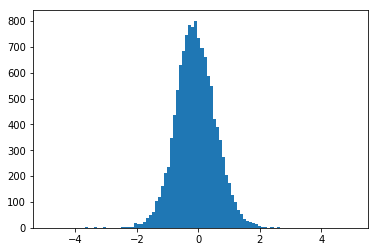

('MIN', -4.8808431625399997, 139)
('MAX', 5.0153727531400003, 1712)


In [129]:
# TODO: Ignore first columns as it's the rid?
i = 5
to_plot = df[df.columns[i]]
plt.hist(to_plot, bins=100)
plt.show()
print('MIN', to_plot.min(), to_plot.idxmin())
print('MAX', to_plot.max(), to_plot.idxmax())
rid = df[0:1].rid.iloc[0]

226